In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import PIL
from PIL import Image

import tensorflow as tf
from tensorflow.python.ops import array_ops
from tensorflow.python.framework import ops

import os
home = os.getenv("HOME")

%matplotlib inline

In [10]:
# Since we've added custom operations, we need to import them. Tensorflow does not automatically add custom ops.
# Adjust the paths below to your tensorflow source folder.

# Import the forward op
roi_pooling_module = tf.load_op_library(
    "../lib/layers/roi_pooling_op.so")
roi_pooling_op = roi_pooling_module.roi_pooling

# Import the gradient op
roi_pooling_module_grad = tf.load_op_library(
    "../lib/layers/roi_pooling_op_grad.so")
roi_pooling_op_grad = roi_pooling_module_grad.roi_pooling_grad

In [94]:
im = Image.open("pano.jpg").convert("L").crop((2100, 500, 2600, 800))

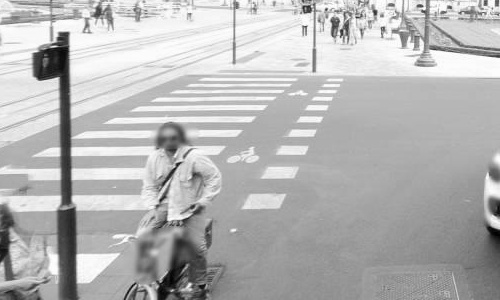

In [95]:
im

In [96]:
image_width, image_height = np.asarray(im).shape

In [97]:
image_width, image_height

(300, 500)

In [102]:
# Prepare demo inputs
num_batches = 1

# Test ROIs
rois = [(0, 0, 300, 500), (150, 150, 150, 50)]
# Data ordering: num batches, num ROIs, (x, y, height, width)
roi_array = np.asarray(rois).astype(int).reshape(len(rois), 4)
roi_array = np.asarray([roi_array for i in range(num_batches)])


input_image = im.crop((0, 0, image_width, image_height))
# Should be in NCHW format (num batches, num channels, height, width)
input_array = np.asarray(input_image).reshape(1, image_height, image_width)
input_array = np.asarray([input_array for i in range(num_batches)])

# Output should be a tensor of this shape
# height, width
output_shape = np.asarray((50, 80)).astype(np.int32)

# Prepare an array of random numbers to test gradient backpropagation
# Should be same size as output of ROI pooling layer
grad_test = np.random.random((1, 1, len(roi_array), output_shape[0], output_shape[1]))

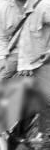

In [103]:
im.crop((rois[1][0], rois[1][1], rois[1][3] + rois[1][0], rois[1][2] + rois[1][1]))

In [83]:
# Here we register our gradient op as the gradient function for our ROI pooling op. 
#@ops.RegisterGradient("RoiPooling")
def _roi_pooling_grad(op, grad0, grad1):
    # The input gradients are the gradients with respect to the outputs of the pooling layer
    input_grad = grad0
    
    # We need the argmax data to compute the gradient connections
    argmax = op.outputs[1]
    
    # Grab the shape of the inputs to the ROI pooling layer
    input_shape = array_ops.shape(op.inputs[0])
    
    # Compute the gradient
    backprop_grad = roi_pooling_op_grad(input_grad, argmax, input_shape)
    
    # Return the gradient for the feature map, but not for the other inputs
    return [backprop_grad, None, None]

In [84]:
# Set up the TensorFlow operations to test

# Placeholders are placeholders for the input data. Passed in for each computation.
data = tf.placeholder(tf.float32)
rois = tf.placeholder(tf.int32)
grad = tf.placeholder(tf.float32)
output_shape_tensor = tf.placeholder(tf.int32)

# Get the shape of the input feature map
input_shape = array_ops.shape(data)

# We can use either the CPU or GPU. Here we'll use the gpu. Other examples test both implementations.
with tf.device("/gpu:0"):
    # Compute the forward pass - returns the feature map and the argmax data for backprop
    result, argmax = roi_pooling_op(data, rois, output_shape_tensor)

    # Compute the backwards pass - the gradient between result and data.
    # Calls the registered gradient operation
    gradient, = tf.gradients(result, data)

In [85]:
# Set up a Tensorflow session
sess = tf.InteractiveSession()

In [86]:
# Run the forward pass. We ask for result and argmax to be computed, and pass
# in a feed dictionary to fill in the placeholders.
# result_out is the computed pooled feature map.
# argmax_out contains the location the max pixels were found

result_out, argmax_out = \
    sess.run([result, argmax], \
             feed_dict={data:input_array, rois:roi_array, grad:grad_test, output_shape_tensor:output_shape})

In [87]:
# Run the backward pass. 
gradient_out, = \
    sess.run([gradient], \
        feed_dict={data:input_array, rois:roi_array, grad:grad_test, output_shape_tensor:output_shape})

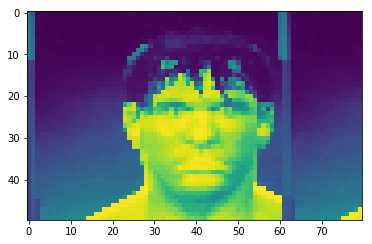

In [88]:
# Display the result of pooling the first ROI
plt.imshow(result_out[0, 0, 0, :, :].reshape(output_shape))

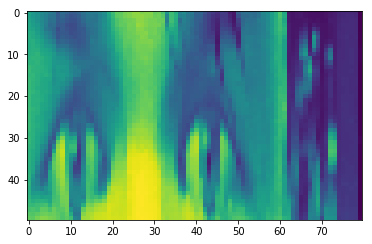

In [89]:
# Display the result of pooling the first ROI
plt.imshow(result_out[0, 0, 1, :, :].reshape(output_shape))